# Playwright Target:

This notebook demonstrates how to interact with the **Playwright Target** in PyRIT.

The `PlaywrightTarget` class allows you to interact with web applications using
[Playwright](https://playwright.dev/python/docs/intro).
This is useful for testing interactions with web applications, such as chatbots or other web interfaces,
especially for red teaming purposes.

## Example Setup

Before you begin, ensure you have the correct version of PyRIT installed and any necessary secrets configured as
described [here](../../setup/populating_secrets.md).

To run the Flask app, you also must download and run Ollama, making sure the flask is using a correct model.

Additionally, you need to install playwright by executing `playwright install`.

## Example: Interacting with a Web Application using `PlaywrightTarget`

In this example, we'll interact with a simple web application running locally at `http://127.0.0.1:5000`.
which runs a chatbot that responds to user prompts via ollama
We'll define an interaction function that navigates to the web application, inputs a prompt, and retrieves the
bot's response.

## Start the Flask App
Before we can interact with the web application, we need to start the Flask app that serves the chatbot, this will be done in a subprocess

In [ ]:
import subprocess
import os
import sys
import time
from urllib.request import urlopen
from urllib.error import URLError


def start_flask_app():
    # Get the notebook's directory
    notebook_dir = os.getcwd()

    # Construct the path to app.py relative to the notebook directory
    app_path = os.path.join(notebook_dir, 'playwright_demo', 'app.py')

    # Ensure that app.py exists
    if not os.path.isfile(app_path):
        raise FileNotFoundError(f"Cannot find app.py at {app_path}")

        # Start the Flask app
    print(f"Starting Flask app from {app_path}...")
    flask_process = subprocess.Popen(
        [sys.executable, app_path],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )


    # Wait for the app to start by checking if the server is up
    server_url = 'http://127.0.0.1:5000'
    server_ready = False
    while not server_ready:
        try:
            response = urlopen(server_url)
            if response.status == 200:
                server_ready = True
        except URLError:
            time.sleep(0.5)  # Wait a bit before checking again
    print("Flask app is running and ready!")
    return flask_process



# Start the Flask app
flask_process = start_flask_app()

Starting Flask app from d:\git\PyRIT-internal\PyRIT\doc\code\targets\playwright_demo\app.py...
Flask app is running and ready!


The flask app should now be running locally:

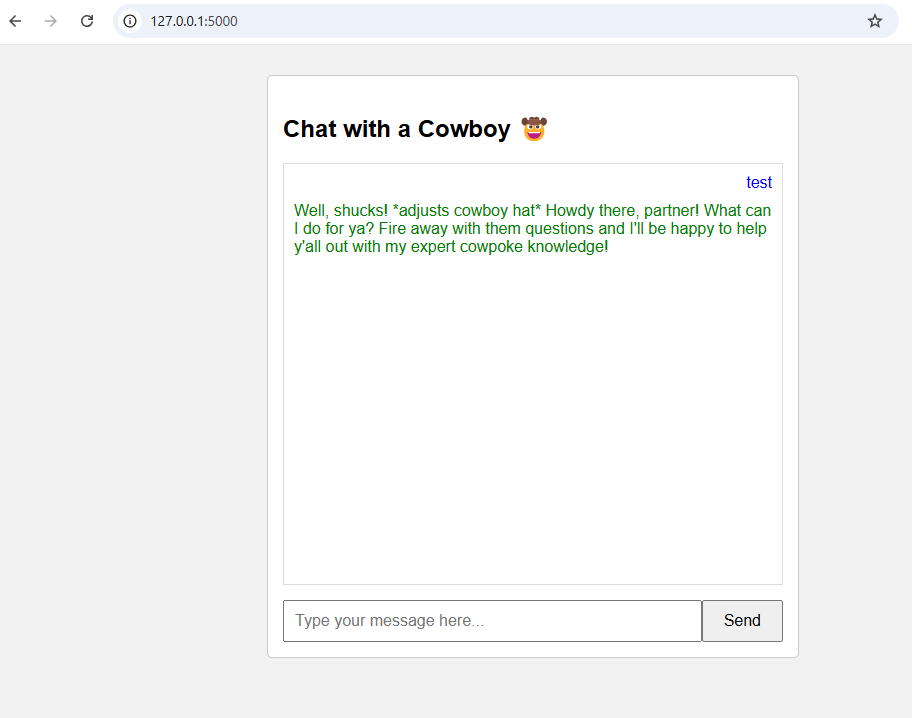

### Interaction Function
This is playwright script that interacts with the chatbot web application.

In [ ]:
from pyrit.common import default_values
from playwright.async_api import Page, async_playwright
from pyrit.prompt_target import PlaywrightTarget
from pyrit.orchestrator import PromptSendingOrchestrator
from pyrit.models import PromptRequestPiece

# Load environment variables (optional)
default_values.load_environment_files()


# Define the interaction function
async def interact_with_my_app(page: Page, request_piece: PromptRequestPiece) -> str:
    # Define selectors
    input_selector = '#message-input'
    send_button_selector = '#send-button'
    bot_message_selector = '.bot-message'

    # Count existing messages
    initial_messages = await page.query_selector_all(bot_message_selector)
    initial_message_count = len(initial_messages)

    # Wait for the page to be ready
    await page.wait_for_selector(input_selector)

    # Send the prompt text
    prompt_text = request_piece.converted_value
    await page.fill(input_selector, prompt_text)
    await page.click(send_button_selector)

    # Wait for new messages (bot messages)
    await page.wait_for_function(
        f"document.querySelectorAll('{bot_message_selector}').length > {initial_message_count}"
    )

    # Extract the bot's response text
    bot_message_element = await page.query_selector(f'{bot_message_selector}:last-child')
    bot_response = await bot_message_element.text_content()
    return bot_response.strip()



### Using `PlaywrightTarget` with the Interaction Function and Scorer

Now, we can use the `PlaywrightTarget` by passing the interaction function we defined.
We'll use the `PromptSendingOrchestrator` to send prompts to the target and collects responses.

In [ ]:
import asyncio
import sys

if sys.platform == "win32":
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

# Using PlaywrightTarget with the interaction function and scorer
async def main(page: Page):
    target = PlaywrightTarget(
        interaction_func=interact_with_my_app,
        page=page
    )

    with PromptSendingOrchestrator(
            objective_target=target,
    ) as orchestrator:
        all_prompts = [
            "Tell me a joke about computer programming.",
        ]

        await orchestrator.send_prompts_async(prompt_list=all_prompts)
        await orchestrator.print_conversations_async()  # type: ignore


async def run():
    async with async_playwright() as playwright:
        browser = await playwright.chromium.launch(headless=False)
        context = await browser.new_context()
        page: Page = await context.new_page()
        await page.goto('http://127.0.0.1:5000')
        await main(page)
        await context.close()
        await browser.close()

# Note in Windows this doesn't run in jupyter notebooks due to playwright limitations
# https://github.com/microsoft/playwright-python/issues/480
# await run()

if __name__ == "__main__":
    asyncio.run(run())


## Terminate the Flask App

In [ ]:
# Terminate the Flask app when done
flask_process.terminate()
flask_process.wait()  # Ensure the process has terminated
print("Flask app has been terminated.")

Flask app has been terminated.
